### Introduction to Machine Learning in Finance and Insurance (Spring 2024)
# Project 1: Credit Analytics

### Team members: LastName1 FirstName1, LastName2 FirstName2, LastName3 FirstName3

In [258]:
### Import all the Python libraries you are going to use
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [259]:
### Fix random seed for reproducibility
np.random.seed(10)

# Exercise 1. Dataset features generation.

In [260]:
# Data set params
age_lower_bound = 18
age_upper_bound = 80.000001

income_lower_bound = 1
income_upper_bound = 15.000001

p_self_emplyed = .1

# train set power
m = int(2e4)
# test set power
n = int(1e4)

feature_headers = ['age', 'income', 'salaried']

# Age ,income and employment data
data = pd.DataFrame((np.random.uniform(age_lower_bound,age_upper_bound, m+n),
                     np.random.uniform(income_lower_bound,income_upper_bound, m+n),
                     np.random.binomial(1, p_self_emplyed, size = m+n))).transpose()
data.columns=feature_headers

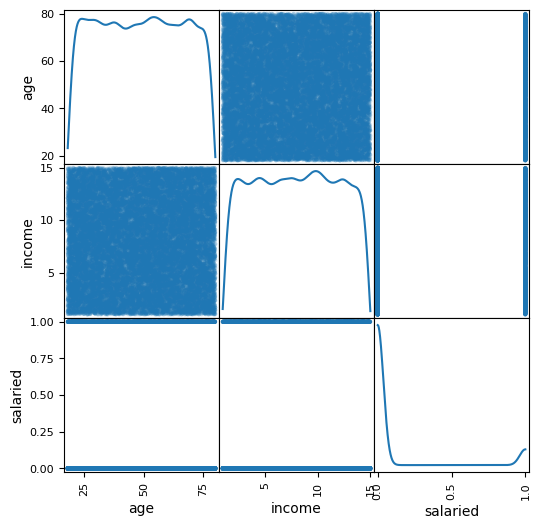

In [261]:
# Plot scatter matrix
pd.plotting.scatter_matrix(data, alpha=0.2, figsize=(6, 6),diagonal='kde')
plt.show()

1. We can observe that features have aproximately distributions as specified in the requirements
2. Features are independent of eachother

# Exercise 2. Dataset labels generation.

In [262]:
# Define logistic function
def logistic(z:float) -> float:
    return 1 / (1 + np.exp(-z))

# Define p1 parameters and function
p1_intecept = -13.3
p1_coeff = np.array([0.33,-3.5,3])

def p1(intecept: float, coeff: float, row:float) -> float:
    z = intecept + np.dot(coeff, row)
    return logistic(z)

# Define p2 parameters and function
p2_intecept = -5
p2_coeff = np.array([10,-1.1,1])
age_lower_bound = 25
age_upper_bound = 75


def indic(low_bound: float, up_bound: float):
    assert low_bound <= up_bound, 'lower boundry has to be less or equal to upper boundry'
    def arg(x):
        return 1 if x < low_bound else -1 if x > up_bound else 0
    return arg

def p2(intecept: float, coeff: float, row:float)-> float:
    p2_indicator = indic(age_lower_bound, age_upper_bound)
    
    row_trasformed = row.copy()
    row_trasformed.loc['age'] = p2_indicator(row_trasformed.loc['age'])
    
    z = intecept + np.dot(coeff, row_trasformed)
    return logistic(z)

In [263]:
df_prob = pd.DataFrame()
df_prob['p_1'] = data.apply(lambda row: p1(p1_intecept, p1_coeff, row), axis = 1)
df_prob['p_2'] = data.apply(lambda row: p2(p2_intecept, p2_coeff, row), axis = 1)

df_prob.describe()

,p_1,p_2
count,3.000000e+04,3.000000e+04
mean,5.039505e-02,3.052735e-02
std,1.953120e-01,1.482675e-01
min,1.115391e-26,2.127544e-14
25%,8.564344e-17,1.735934e-08
50%,1.575547e-11,1.587108e-06
75%,2.932197e-06,1.347307e-04
max,9.999963e-01,9.921268e-01


In [264]:
df_default = pd.DataFrame()
for i, col in enumerate(df_prob.columns):
    df_default['y_'+str(i+1)] = np.random.binomial(1, df_prob[col])


In [265]:
# Split into test train datasets
X_train = data.loc[:m-1]
X_test = data.loc[m:]

Y_train = df_default.loc[:m-1]
Y_test = df_default.loc[m:]

In [266]:
print('Summary:',
       data.head(),
       data.describe(),
       df_default.value_counts(['y_1'], normalize=True),
       df_default.value_counts(['y_2'], normalize=True),
       sep='\n')

Summary:
         age     income  salaried
0  65.821881   6.120547       1.0
1  19.286621   4.550855       0.0
2  57.286191   6.995290       0.0
3  64.425841   4.681818       0.0
4  48.907435  13.712852       0.0
                age        income      salaried
count  30000.000000  30000.000000  30000.000000
mean      48.844797      7.987606      0.101033
std       17.965029      4.026278      0.301378
min       18.004268      1.000025      0.000000
25%       33.195964      4.498722      0.000000
50%       48.927875      7.995084      0.000000
75%       64.411589     11.453036      0.000000
max       79.999369     14.999594      1.000000
y_1
0      0.948633
1      0.051367
Name: proportion, dtype: float64
y_2
0      0.9699
1      0.0301
Name: proportion, dtype: float64


# Exercise 3. Model implementations.

In [267]:
from sklearn.linear_model import LogisticRegression # logistic regression model
from sklearn.metrics import log_loss # Cross-entropy
from typing import Union

import keras

### 3a) Logistic regression (LR)

In [268]:
# Create container for the model and it's main characteristics
class ml_model():
    def __init__(self,
                 name: str,
                 model: Union[LogisticRegression, keras.src.models.sequential.Sequential]):
        self._name = name
        self._model = model
        self._type = type(model)
    @property
    def log_loss_train(self) -> float:
        return self._log_loss_train
    
    @log_loss_train.setter
    def log_loss_train(self, loss: float):
        self._log_loss_train = loss

    @property
    def log_loss_test(self) -> float:
        return self._log_loss_test
    
    @log_loss_test.setter
    def log_loss_test(self, loss: float):
        self._log_loss_test = loss

    @property
    def model(self) -> float:
        return self._model

    @property
    def history(self) :
        return self._history
    
    @history.setter
    def history(self, history):
        self._history = history

    @property
    def model_type(self) -> str:
        return self._type    

    def __str__(self):
        return f'ML model: {self._name} \n type:{self._type}'

In [269]:
# Implement and train a logistic regression model
# You can use LogisticRegression() from sklearn.linear_model (see the notebook "Project 1 - Sandbox.ipynb")
# For more information, see: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

# Attention! Set the argument penalty=None to implement a logistic regression without regularization
lr_models = []
for i, col in enumerate(Y_train.columns):
    lr = ml_model(name = 'LR_Default_'+ str(i+1),
                  model = LogisticRegression(penalty=None).fit(X_train, Y_train[col]))
    lr.log_loss_train = log_loss(Y_train[col], lr.model.predict_proba(X_train)[:,1])
    lr.log_loss_test = log_loss(Y_test[col], lr.model.predict_proba(X_test)[:,1])                   
    lr_models.append(lr)

In [270]:
# Compute the cross-entropy loss on the training and test data.
for i, lr in enumerate(lr_models):   
    print(lr,
          f'Coefficients: {lr.model.coef_}',
          f'Intercept: {lr.model.intercept_}',
          f'Log loss on train data: {lr.log_loss_train:.4f}',
          f'Log loss on test data: {lr.log_loss_test:.4f}',          
          '', sep='\n')

ML model: LR_Default_1 
 type:<class 'sklearn.linear_model._logistic.LogisticRegression'>
Coefficients: [[ 0.31819676 -3.48603826  3.37099418]]
Intercept: [-12.41238575]
Log loss on train data: 0.0319
Log loss on test data: 0.0356

ML model: LR_Default_2 
 type:<class 'sklearn.linear_model._logistic.LogisticRegression'>
Coefficients: [[-0.52549416 -0.9018388   0.48466929]]
Intercept: [14.84108434]
Log loss on train data: 0.0375
Log loss on test data: 0.0372



In [271]:
# For comaprison log loss based on the naive prediction (ie. frequency in Y_train data)
naive_pred_1 = Y_train['y_1'].value_counts(normalize=True)[1]
naive_pred_2 = Y_train['y_2'].value_counts(normalize=True)[1]

log_loss_naive_1_train = log_loss(Y_train['y_1'], [naive_pred_1] * Y_train.shape[0])
log_loss_naive_1_test = log_loss(Y_test['y_1'], [naive_pred_1] * Y_test.shape[0])

log_loss_naive_2_train = log_loss(Y_train['y_2'], [naive_pred_1] * Y_train.shape[0])
log_loss_naive_2_test = log_loss(Y_test['y_2'], [naive_pred_1] * Y_test.shape[0])

print(naive_pred_1, log_loss_naive_1_train, log_loss_naive_1_test,'', sep='\n')
print(naive_pred_2, log_loss_naive_2_train, log_loss_naive_2_test,'', sep='\n')

0.0514
0.20261700624514914
0.20232547134105094

0.03015
0.14066583912427394
0.14022853676812658



Comments:
* Logistic regression learned intercept and covariates well in p1 case
* With non linearity in the model, logistic regression based on linear predictor has
problems with finding good parameters
* Both models perform better than naive model 

### 3b) Neural network (NN)

In [272]:
import keras
# Implement and train a neural network model
# You can use Keras (see the notebook "Project 1 - Credit risk - Sandbox")
# For more information, see: https://keras.io/getting_started/

# Number of neurons in the hidden layer
neuron_count = 50
batch_size = 1024 # Size of batches in stochastic gradient descent
epochs = 100 # Number of iterations on dataset

nn_models = []
for i, col in enumerate(Y_train.columns):
    nn_name = f'neural_network_{i}'
    locals()[nn_name] = keras.Sequential([keras.layers.Dense(neuron_count, activation='relu'),
                                        keras.layers.Dense(neuron_count, activation='relu'),
                                        keras.layers.Dense(1, activation='sigmoid')])
    
    # Compile the network
    # We choose Adam as gradient descent algorithm and cross-entropy as loss function
    lr = 0.01 # learning rate
    locals()[nn_name].compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
                        loss=keras.losses.BinaryCrossentropy())    
    
    nn_model = ml_model('NN_Default_'+ str(i+1),
                        model = locals()[nn_name])
    # Train the model
    nn_model.history = nn_model.model.fit(x=X_train, y=Y_train[col], batch_size=batch_size, epochs=epochs)
    nn_models.append(nn_model)


Epoch 1/100


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.4704
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2558 
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1039 
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0673 
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0522 
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0487 
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0460
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0434
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0522
Epoch 10/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0400
Epoch 11/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0377
Epoch 12/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0380
Epoch 13/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0356
Epoch 14/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0384
Epoch 15/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0379
Epoch 16/10

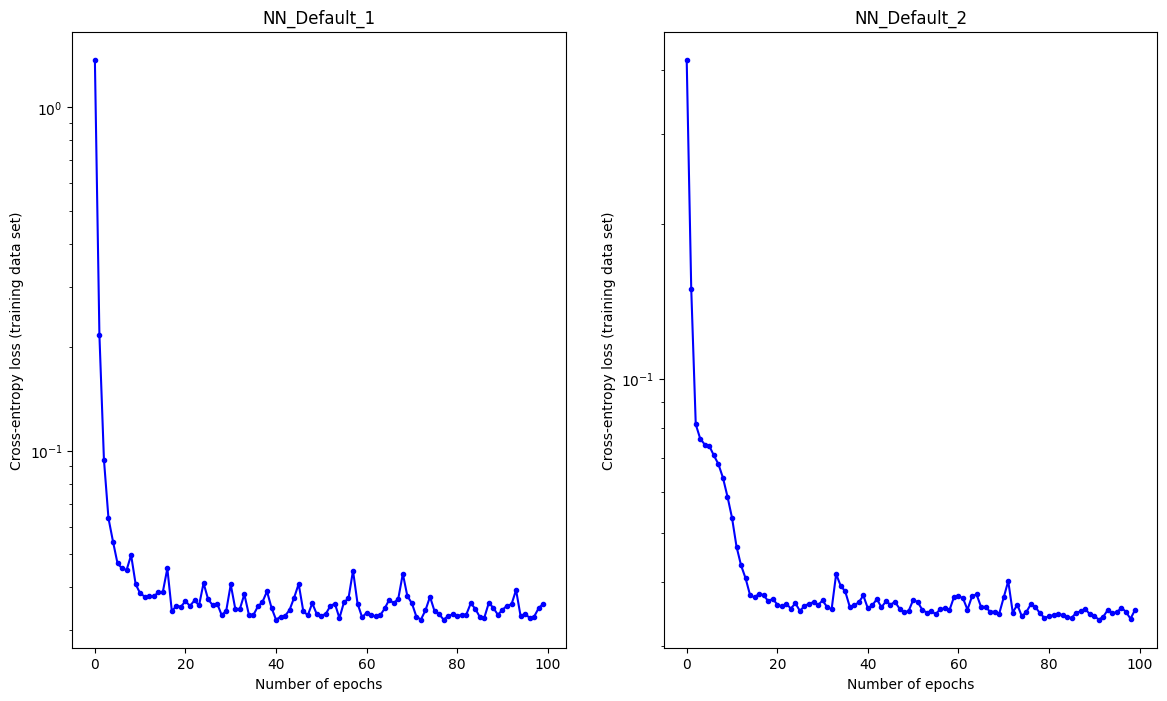

In [273]:
# Plot the cross-entropy loss during training
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(14,8))
for i, nn in enumerate(nn_models):
    hist = nn.history
    ax[i].plot(hist.history['loss'], 'b.-')
    ax[i].set_title(nn._name)

    ax[i].set_yscale('log')
    ax[i].set_ylabel('Cross-entropy loss (training data set)')
    ax[i].set_xlabel('Number of epochs')
plt.show()

In [274]:
# Compute the cross-entropy loss on the training and test data.
for i, nn in enumerate(nn_models):
    print(nn)
    print(f'Cross-entropy (train): {log_loss(Y_train.iloc[:,i], nn.model.predict(X_train)):.4f}')
    print(f'Cross-entropy (test): {log_loss(Y_test.iloc[:,i], nn.model.predict(X_test)):.4f}')

ML model: NN_Default_1 
 type:<class 'keras.src.models.sequential.Sequential'>
  1/625 ━━━━━━━━━━━━━━━━━━━━ 1:32 148ms/step

625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
Cross-entropy (train): 0.0324
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Cross-entropy (test): 0.0372
ML model: NN_Default_2 
 type:<class 'keras.src.models.sequential.Sequential'>
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
Cross-entropy (train): 0.0338
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Cross-entropy (test): 0.0334


Comments:

* NN_Default_1 is slightly worse when compared to LR_Default_1
* NN_Default_2 seems to perform well, ie much better than logistic regression

To do:
* improve network params, loss graph for network2 looks poor, network1 - can it do equally well as logistic regression?
* caluclate minimal loss using parameters p_1 and p_2


### 3c) ROC curves and AUC scores

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


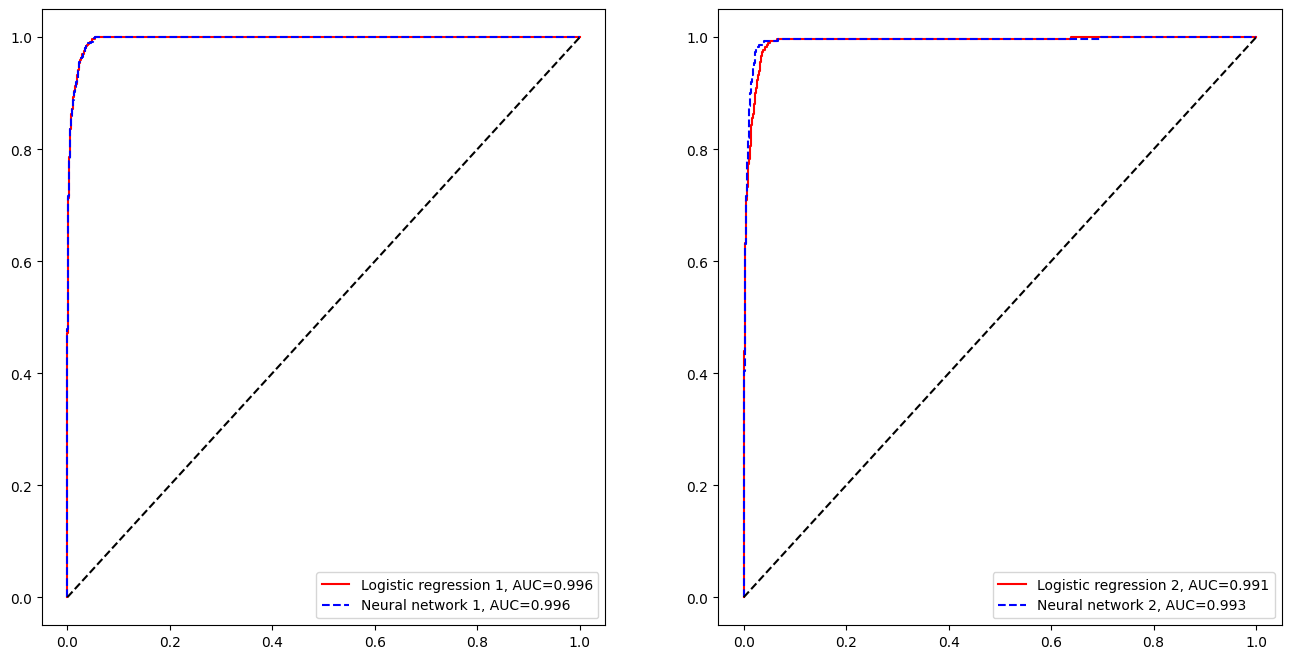

In [275]:
# Plot the ROC curves and compute the AUC scores
# You can use roc_auc_score and roc_curve from sklearn.metrics
from sklearn.metrics import roc_auc_score, roc_curve

# Select models for comaprison

fig, ax = plt.subplots(1,2,figsize= [16, 8])

for model in range(2):
    fpr_LR, tpr_LR, thresholds_LR = roc_curve(Y_test.iloc[:,model], lr_models[model].model.predict_proba(X_test)[:, 1], pos_label=1)
    auc_LR = roc_auc_score(Y_test.iloc[:,model], lr_models[model].model.predict_proba(X_test)[:, 1])

    # Compute FPR and TPR for neural network
    fpr_NN, tpr_NN, thresholds_NN = roc_curve(Y_test.iloc[:,model], nn_models[model].model.predict(X_test), pos_label=1)
    auc_NN = roc_auc_score(Y_test.iloc[:,model], nn_models[model].model.predict(X_test))

    # Create plot
    ax[model].plot(fpr_LR, tpr_LR, 'r-', label=f'Logistic regression {model + 1}, AUC={auc_LR:.3f}') #.format(auc_LR)
    ax[model].plot(fpr_NN, tpr_NN, 'b--', label=f'Neural network {model + 1}, AUC={auc_NN:.3f}') #.format(auc_NN)
    ax[model].plot([0, 1], [0, 1], 'k--')
    ax[model].legend()

plt.show()

# Exercise 4. Comparison of lending strategies

In [276]:
# Implement a function to compute the Value at Risk (VaR) at level alpha on the vector x
def var(x, alpha):
    x_sorted = np.sort(x)
    return x_sorted[int(len(x)*alpha)]

In [277]:
# Simulate scenario matrix
prob_set = 2 # Which set of probabilities, defined at the start, are we interested in {1,2}

df_test_prob = df_prob.iloc[m:,prob_set-1] # p2, test subset of full probability matrix (ie corresponding to Y_test seconde column)

df_scenarios = pd.DataFrame()
num_cols = df_test_prob.shape[0]
num_rows = int(1e3)

df_scenarios = pd.DataFrame(np.random.binomial(1, p=df_test_prob,size=(num_rows, num_cols))).transpose()

In [278]:
# Check scenarios, should be small. Cumulative difference of mean estimators and 10000 test set means (ie probability of a success in Bernouli trail)
sum(df_scenarios.sum(axis=1)/num_rows) - sum(df_test_prob)

0.34690986765724574

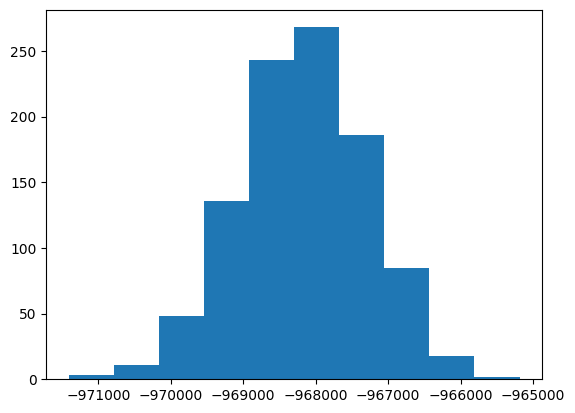

95% VaR of strategy (i): 969721.5


In [279]:
alpha = 0.95
# Implement strategy (i), plot the P&L histogram and compute VaR(95%) of the losses
ir = 5.5/100
loan = 100

investment = 100 * n

# Calculate return per scenario
return_t1 = [loan * (1 + ir)] * n @ df_scenarios

# Calculate profit&loss
P_L_1 = return_t1 - investment

plt.hist(P_L_1)
plt.show()
print(f'95% VaR of strategy (i): {var(-P_L_1, alpha)}')

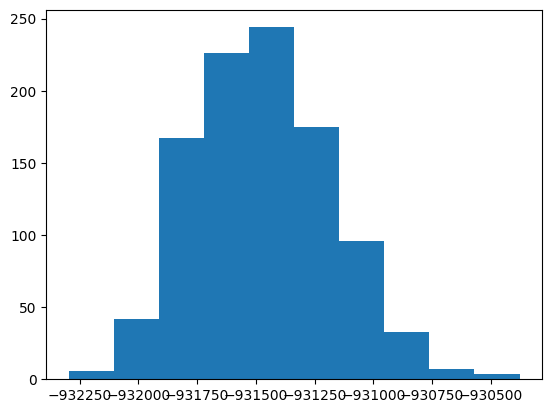

95% VaR of strategy (ii): [931489.]


In [280]:
# Implement strategy (ii), plot the P&L histogram and compute VaR(95%) of the losses
ir = 1/100
loan = 100
application_treshold = 5/100

lr_model = lr_models[1].model
LR2_prob = lr_model.predict_proba(X_test)[:,1]

select_applicants = LR2_prob <= application_treshold

investment = 100 * sum(select_applicants)

# Calculate return per scenario
return_t1 = pd.DataFrame([100 * (1+ir)] * sum(select_applicants)
                         @ df_scenarios[select_applicants])

# Calculate profit&loss per scenario
P_L_2 = return_t1 - investment

plt.hist(P_L_2)
plt.show()
print(f'95% VaR of strategy (ii): {var(-P_L_2, alpha)}')


 14/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step  

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step


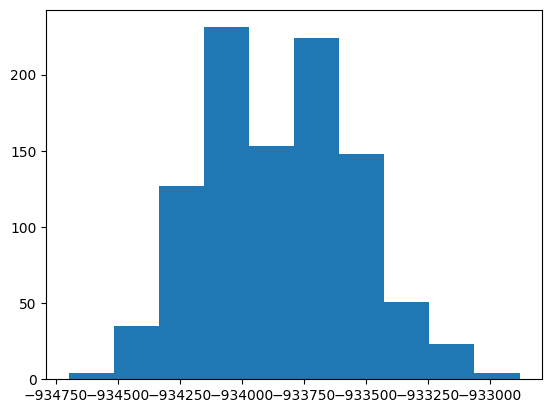

95% VaR of strategy (i): [934295.]


In [255]:
# Implement strategy (iii), plot the P&L histogram and compute VaR(95%) of the losses
# Implement strategy (ii), plot the P&L histogram and compute VaR(95%) of the losses
ir = 1/100
loan = 100
application_treshold = 5/100

nn_model = nn_models[1].model
nn2_prob = nn_model.predict(X_test)

select_applicants = nn2_prob <= application_treshold

investment = 100 * select_applicants.sum()

# Calculate return per scenario
return_t1 = pd.DataFrame([100 * (1+ir)] * select_applicants.sum()
                          @ df_scenarios[select_applicants])

# Calculate profit&loss per scenario
P_L_3 = return_t1 - investment

plt.hist(P_L_3)
plt.show()
print(f'95% VaR of strategy (iii): {var(-P_L_3, alpha)}')
